<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Skin Cancer Detection using EfficientNET with Fairness Evaluation</b></div>

## Skin Cancer Detection: A Fusion of Innovation and Responsibility
<div style="text-align: justify;">
Skin cancer stands as the most prevalent human malignancy and presents a significant medical challenge due to the visual nuances of skin lesions, often complicating accurate and early diagnosis. In a world where precision is critical, can artificial intelligence offer a transformative approach to this fight? Enter the HAM10000 dataset ("Human Against Machine with 10,000 training images"), a valuable resource for researchers and data scientists. This dataset comprises 10,015 dermatoscopic images and serves as a crucial asset in the quest for automated skin cancer classification, encompassing seven distinct classes:</div>
    <ol>
        <li>Melanocytic nevi</li>
        <li>Melanoma</li>
        <li>Benign keratosis-like lesions</li>
        <li>Basal cell carcinoma</li>
        <li>Actinic keratoses</li>
        <li>Vascular lesions</li>
        <li>Dermatofibroma</li>
    </ol>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="import"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Importing Important Libraries</b></div>

In [23]:
import os
import sys
import time
import copy
from glob import glob
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import cv2
from PIL import Image
import shutil

from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression

import skimage

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

np.random.seed(222)

from IPython.display import YouTubeVideo
import albumentations as A

# Set environment settings and pandas display options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Setting styles
sns.set_style('darkgrid')

# Warning settings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print('All modules have been imported')

All modules have been imported


<a id="pre"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> Data Preprocessing</b></div>

This code is setting up the initial data processing for the HAM10000 skin cancer dataset. Here's a brief explanation of its purpose:

- Define Dataset Path: Establish the base directory for the dataset.
Map Image Paths: Create a dictionary mapping image IDs to their respective file paths.
- Lesion Type Mapping: Define a dictionary that maps lesion type codes to their descriptive names.
- Load Metadata: Read the metadata CSV file containing image and diagnosis information.
- Add Image Paths: Map image IDs in the metadata to their file paths.
- Map Lesion Types: Map diagnosis codes to their descriptive names in the metadata.
- Categorize Lesion Types: Convert the lesion type names to categorical codes.
- Sample Data: Display a sample of three rows from the processed metadata DataFrame.
This preprocessing prepares the data for further analysis and model training.

In [24]:
base_skin_dir = os.path.join('/', '/content/drive/MyDrive/dataset/HAM-Data')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

lesion_id      image_id   dx    dx_type   age   sex     localization  \
99    HAM_0002957  ISIC_0026153  bkl      histo  70.0  male             back   
8376  HAM_0000188  ISIC_0028390   nv      histo  40.0  male          abdomen   
3606  HAM_0003674  ISIC_0028660   nv  follow_up  45.0  male  lower extremity   

                                                                                 path  \
99    /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0026153.jpg   
8376  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0028390.jpg   
3606  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0028660.jpg   

                           cell_type  cell_type_idx  
99    Benign keratosis-like lesions               2  
8376                Melanocytic nevi              4  
3606                Melanocytic nevi              4

The code creates two DataFrames (`df` and `df2`) for the HAM10000 dataset, preparing the data for further analysis or model training. It starts with an empty DataFrame `df`, then assigns the 'filepaths' column to the image paths from `tile_df` and the 'labels' column to the categorical lesion type indices from `tile_df`. The labels are converted to strings. The first few rows of `df` are displayed.

Next, it creates a second DataFrame `df2`, setting the 'filepaths' and 'labels' columns similarly to `df` and converting the labels to strings. Additionally, 'age' and 'sex' columns from `tile_df` are added to `df2`. Finally, the first few rows of `df2` are displayed.

`df` contains the file paths and labels of the images, while `df2` includes additional demographic information (age and sex) along with the file paths and labels.

In [25]:
df = pd.DataFrame() # columns=["filepaths", "labels"]

df['filepaths'] =tile_df['path']
df['labels'] =tile_df['cell_type_idx']
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

filepaths  \
0  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0027419.jpg   
1  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0025030.jpg   
2  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0026769.jpg   
3  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0025661.jpg   
4  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_2/ISIC_0031633.jpg   

  labels  
0      2  
1      2  
2      2  
3      2  
4      2

In [26]:
# This df will be used for fairness evaluation
df2 = pd.DataFrame()

df2['filepaths'] = tile_df['path']
df2['labels']    = tile_df['cell_type_idx']
df2['labels']    = df['labels'].apply(lambda x: str(x))
df2['age']       = tile_df['age']
df2['sex']       = tile_df['sex']
df2.head()

filepaths  \
0  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0027419.jpg   
1  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0025030.jpg   
2  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0026769.jpg   
3  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_1/ISIC_0025661.jpg   
4  /content/drive/MyDrive/dataset/HAM-Data/HAM10000_images_part_2/ISIC_0031633.jpg   

  labels   age   sex  
0      2  80.0  male  
1      2  80.0  male  
2      2  80.0  male  
3      2  80.0  male  
4      2  75.0  male

In [27]:
df.labels.unique()

array(['2', '4', '3', '5', '6', '1', '0'], dtype=object)

## Data Splitting
This code defines and uses a function to split a DataFrame into training, validation, and test sets.

1. **Define `split_df` Function**:
   - The function takes a DataFrame `df`, a training set size `trsize`, and a column name `column` to stratify the splits.
   - It splits the DataFrame into a training set (`train_df`) and a remaining set (`dummy_df`) using `train_test_split` with stratification on the specified column.
   - It further splits `dummy_df` into validation (`valid_df`) and test (`test_df`) sets with equal size, also using stratification.
   - It prints the lengths of the resulting DataFrames.
   - The function returns the three DataFrames: `train_df`, `test_df`, and `valid_df`.

2. **Split DataFrame `df`**:
   - The `split_df` function is called with `df`, a training set size of 80% (`.8`), and the 'labels' column.
   - The resulting `train_df`, `test_df`, and `valid_df` are assigned the outputs of the function call.

This process ensures that the data is split into training, validation, and test sets while maintaining the class distribution specified by the 'labels' column.

In [28]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=14, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=14, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


In [29]:
train_df2, test_df2, valid_df2  = split_df(df2, .8, 'labels')

train_df length:  8012   test_df length:  1002   valid_df length:  1001


## Function to Plot the Distribution of Image Counts Across Classes in a DataFrame

In [30]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>55:
        print_in_color('The number of labels is >55, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        if lcount >=8:
            rotation='vertical'
        else:
            rotation='horizontal'
        for i in range(lcount):
            plt.text(i, values[i]/2, str(values[i]),fontsize=12, rotation=rotation, color='yellow', ha='center')
        plt.show()

labels
4    5364
5     890
2     879
1     411
0     262
6     114
3      92
Name: count, dtype: int64


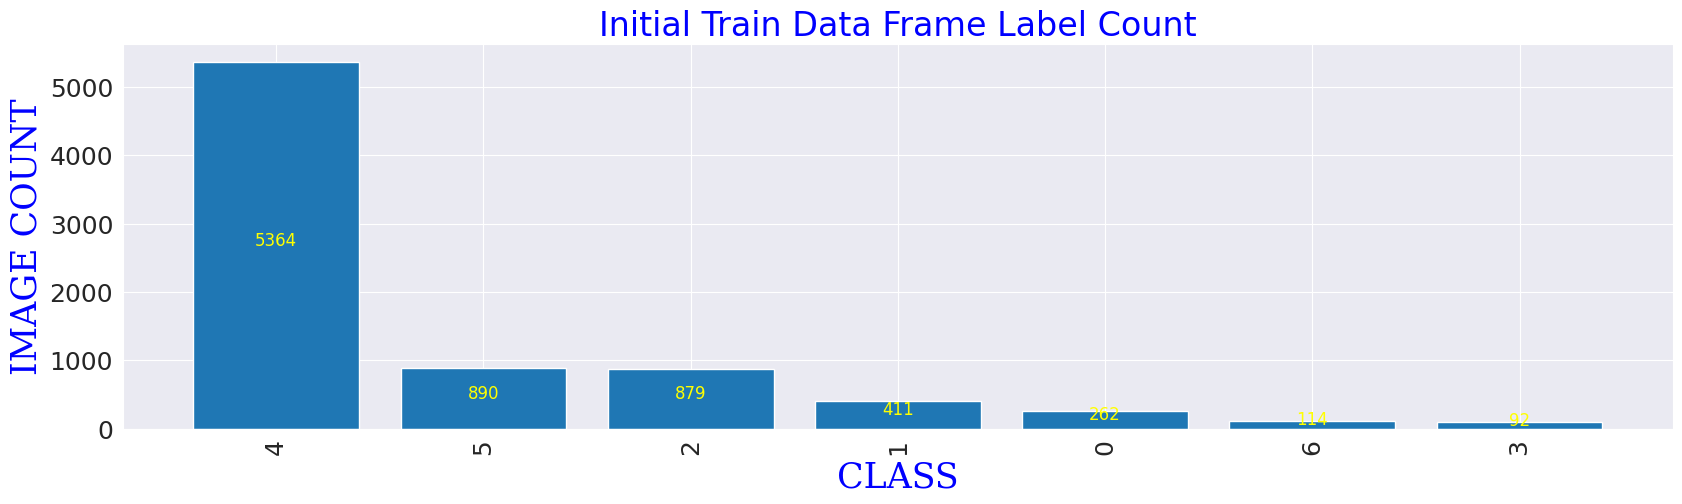

In [31]:
count=train_df['labels'].value_counts()
print (count)
plot_title='Initial Train Data Frame Label Count'
plot_label_count (train_df, plot_title)

<a id="balance"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Resampling</b></div>

This code defines and uses a function to trim a DataFrame by adjusting the number of samples in each class to be within specified limits.

1. **Define `trim` Function**:
   - The function takes a DataFrame `df`, a maximum number of samples `max_samples`, a minimum number of samples `min_samples`, and a column name `column` representing class labels.
   - It makes a copy of the DataFrame to avoid modifying the original.
   - It retrieves the unique classes and their count, printing initial statistics.
   - It initializes an empty DataFrame `trimmed_df` with the same columns as `df`.
   - It groups the DataFrame by the specified column and iterates over each unique class label.
   - For each class, if the count of samples exceeds `max_samples`, it samples `max_samples` from the group; if the count is between `min_samples` and `max_samples`, it keeps the group as is; otherwise, it ignores the group.
   - It concatenates the sampled or original group to `trimmed_df`.
   - It prints statistics of the trimmed DataFrame, including the new length and class count.

2. **Trim Training DataFrame**:
   - The `trim` function is called with `train_df`, a maximum of 1000 samples, a minimum of 10 samples, and the 'labels' column.
   - The resulting `train_df`, unique classes, and class count are assigned the outputs of the function call.

This function ensures that the training DataFrame has a balanced number of samples per class within the specified limits.

In [32]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=1000
min_samples= 10
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

['4' '5' '0' '1' '2' '6' '3']
dataframe initially is of length  8012  with  7  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  10
the trimmed dataframe now is of length  3648  with  7  classes


This code defines and uses a function to balance the dataset by augmenting images so that each class has at least a specified number of samples.

1. **Define `balance` Function**:
   - Takes a DataFrame `df`, a target number of samples per class `n`, the column name `column` for class labels, a working directory `working_dir`, and the target image size `img_size`.
   - Defines two helper functions: `get_augmented_image` for performing image augmentations and `dummy` as a placeholder (not used).
   - Copies the input DataFrame and prints its initial length.
   - Creates an augmentation directory `aug_dir` and ensures it's empty.
   - Creates subdirectories in `aug_dir` for each unique class label.
   - Groups the DataFrame by the specified column.
   - For each class, checks if the number of samples is less than the target `n`:
     - Calculates how many augmented images are needed.
     - Reads the images, applies augmentations, and saves the augmented images in the appropriate class subdirectory.
     - Keeps track of the total number of augmented images created.
   - Prints the total number of augmented images created.
   - Creates a new DataFrame `aug_df` containing the file paths and labels of the augmented images.
   - Merges `aug_df` with the original DataFrame to create a composite DataFrame with augmented data.
   - Prints the length of the augmented DataFrame.
   - Returns the augmented DataFrame.

2. **Balance Training DataFrame**:
   - Calls the `balance` function with `train_df`, a target of 1000 samples per class, the 'labels' column, a working directory, and the image size.
   - The resulting `train_df` is assigned the output of the function call.

This process ensures that each class in the training DataFrame has at least the specified number of samples by augmenting images where necessary.

In [33]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df[column].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=1000
working_dir=r'/content/drive/MyDrive/dataset/HAM-Data/working'
img_size = (310,640)
column='labels'
train_df=balance(train_df, n,column, working_dir, img_size)

Initial length of dataframe is  3648


augmenting class 5:   0%|                                                                    | 0/110 [00:00<?,…

augmenting class 0:   0%|                                                                    | 0/738 [00:00<?,…

augmenting class 1:   0%|                                                                    | 0/589 [00:00<?,…

augmenting class 2:   0%|                                                                    | 0/121 [00:00<?,…

augmenting class 6:   0%|                                                                    | 0/886 [00:00<?,…

augmenting class 3:   0%|                                                                    | 0/908 [00:00<?,…

Total Augmented images created=  3352
Length of augmented dataframe is now  7000


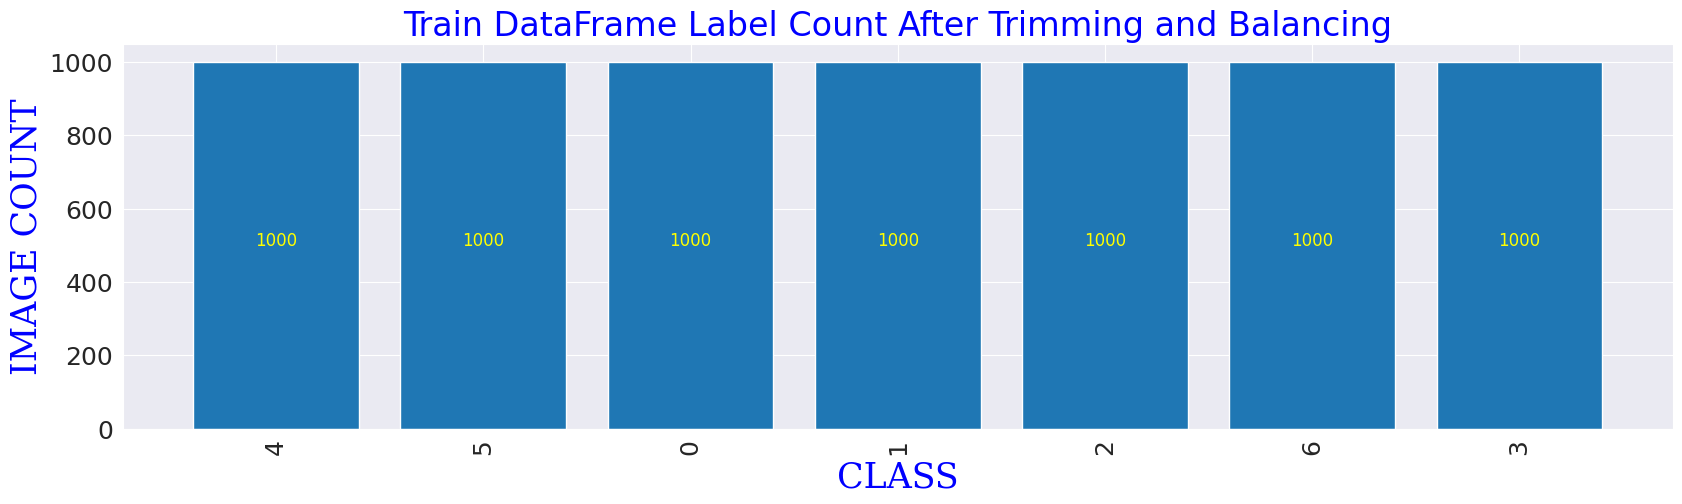

In [34]:
plot_title='Train DataFrame Label Count After Trimming and Balancing'
plot_label_count (train_df, plot_title)

In [35]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=16
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 7000 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
test batch size:  6   test steps:  167  number of classes :  7


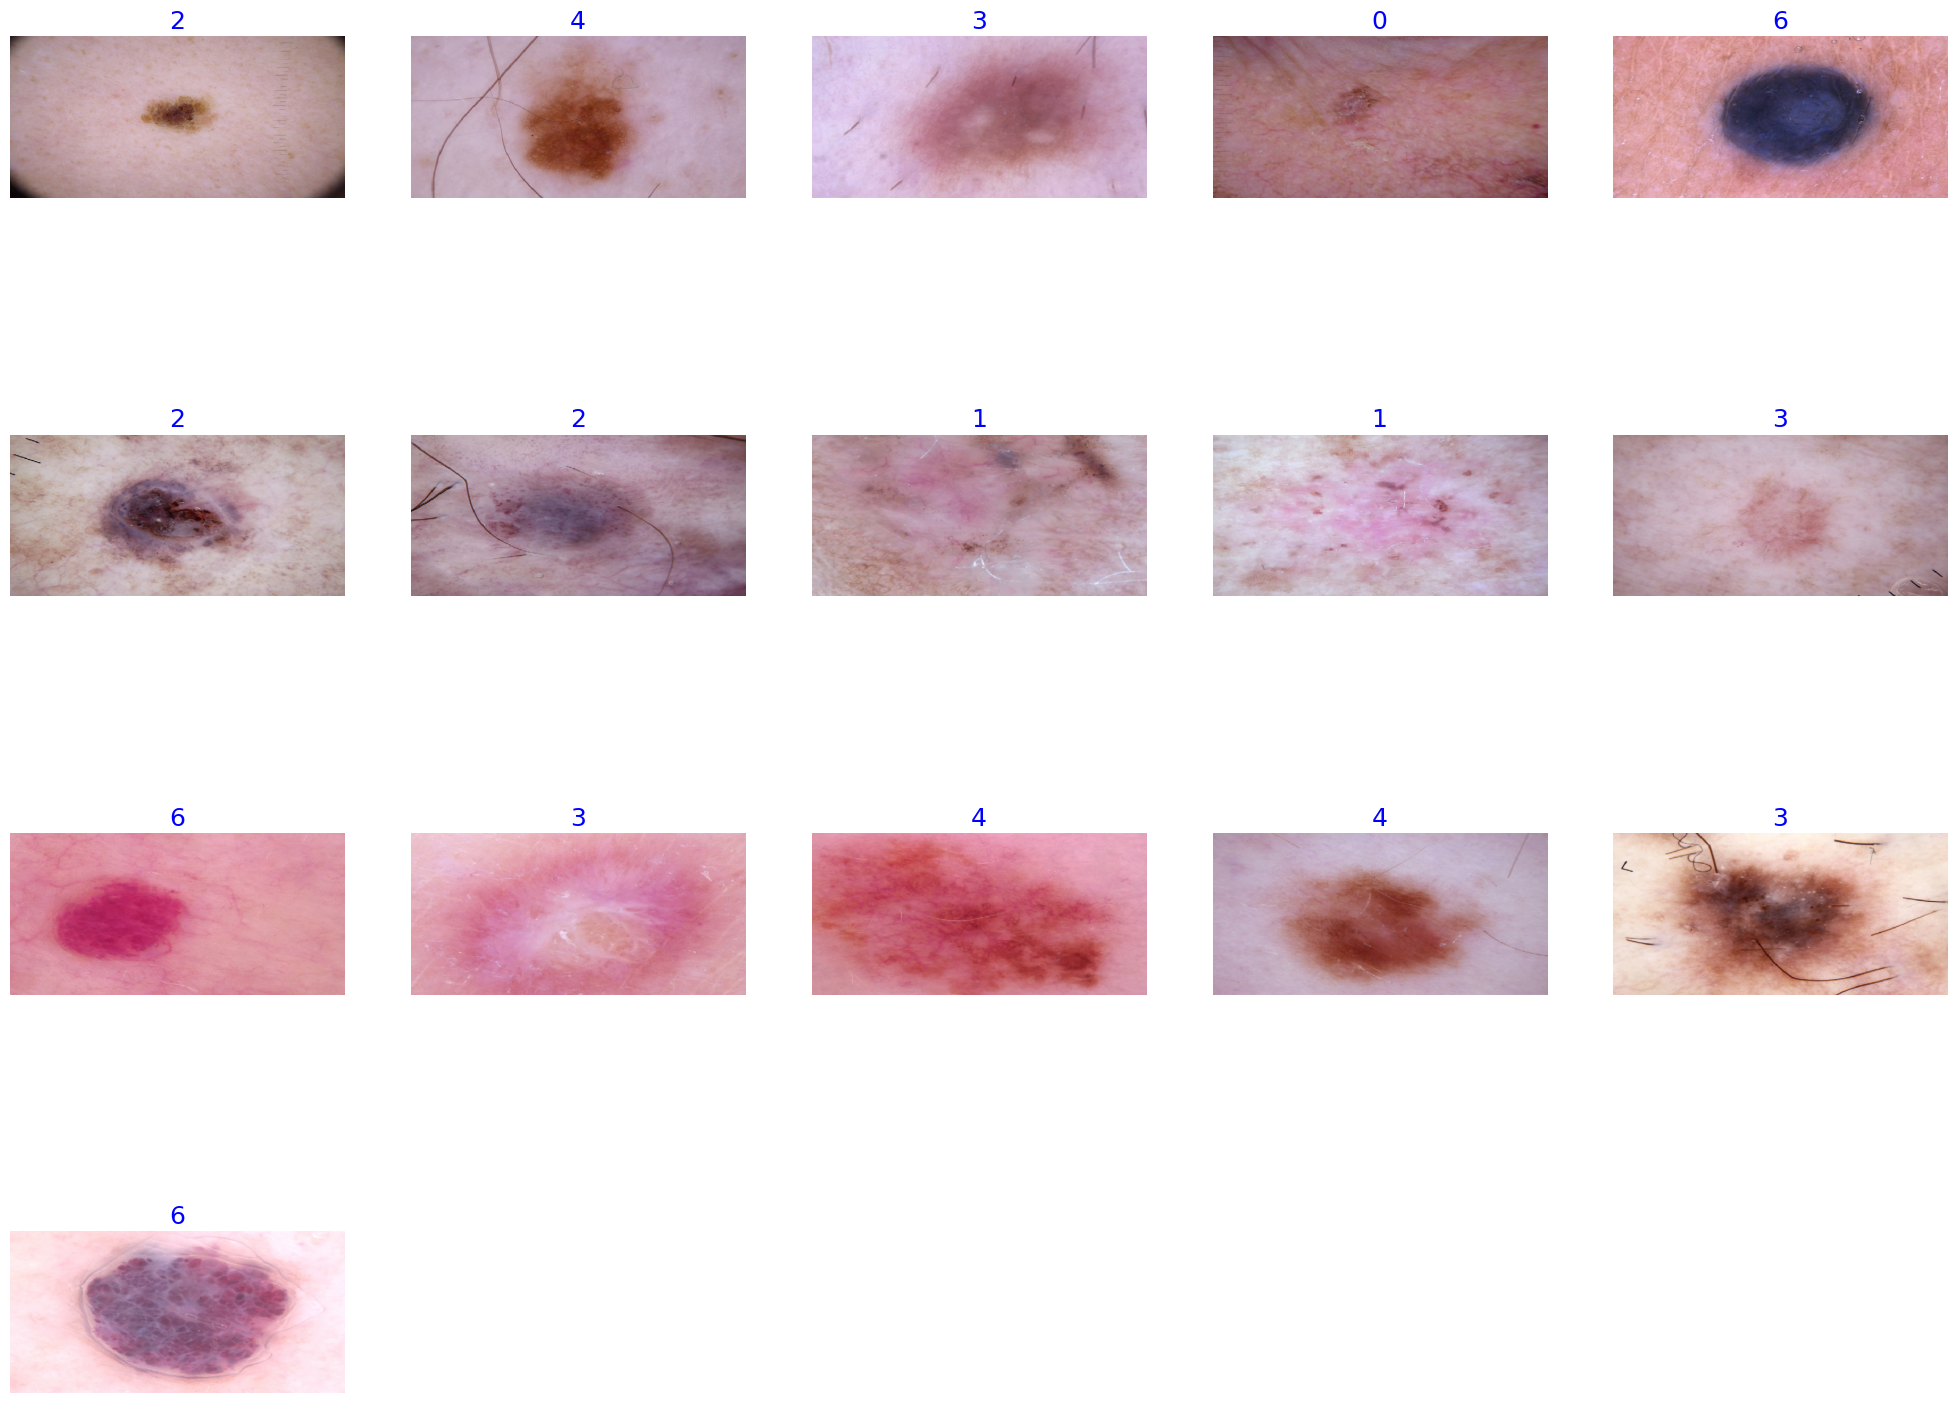

In [36]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

In [37]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [38]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return


<a id="model"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Proposed Model</b></div>

This code defines and uses a function to create a convolutional neural network model based on EfficientNet architectures for image classification.

1. **Define `make_model` Function**:
   - **Parameters**:
     - `img_size`: The dimensions of input images (height, width).
     - `lr`: Learning rate for the optimizer.
     - `mod_num`: An integer to select the EfficientNet version (default is 3 for EfficientNetB3).
   - **Model Selection**:
     - Depending on `mod_num`, it initializes a base model from the EfficientNet family with pre-trained weights and specified input shape.
     - Uses `EfficientNetB0`, `EfficientNetB3`, `EfficientNetB5`, or `EfficientNetB7` based on the value of `mod_num`.
   - **Add Layers**:
     - Adds Batch Normalization to the base model's output.
     - Adds a Dense layer with 256 units and L1/L2 regularization.
     - Adds Dropout for regularization.
     - Adds a final Dense layer with a softmax activation for classification.
   - **Compile Model**:
     - Compiles the model using the Adamax optimizer with the specified learning rate, categorical crossentropy loss, and evaluation metrics including accuracy, F1 score, and AUC.
   - **Print Message**:
     - Prints a message indicating which EfficientNet model was created and the learning rate used.

2. **Create Model**:
   - Calls `make_model` with the specified image size and learning rate, using EfficientNetB3 by default.
   - Assigns the resulting model to the variable `model`.

This function sets up a neural network model with EfficientNet as the backbone and additional custom layers for classification, ready for training and evaluation.

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

def make_model(img_size, lr, mod_num=3):
    img_shape = (img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B5 model'
    else:
        base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B7 model'

    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(l1=0.006), bias_regularizer=regularizers.l1(l1=0.006), activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(class_count, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC'])
    msg = msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr = 0.001
img_size = (224, 224)  # Example image size, adjust as needed
class_count = 10  # Example number of classes, adjust as needed
model = make_model(img_size, lr)  # Using B3 model by default


Created EfficientNet B3 model with initial learning rate set to 0.001



In [41]:
def make_model(img_size, lr, mod_num=3):
    """
    Creates and compiles a Keras model using EfficientNet with additional layers.

    Parameters:
    - img_size (tuple): Size of the input images (height, width).
    - lr (float): Learning rate for the optimizer.
    - mod_num (int): EfficientNet model version (0, 3, 5, or default for B7).

    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    img_shape = (img_size[0], img_size[1], 3)

    if mod_num == 0:
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B5 model'
    else:
        base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
        msg = 'Created EfficientNet B7 model'

    base_model.trainable = True
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    output = Dense(class_count, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adamax(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1_score, 'AUC'])

    msg = msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model


In [42]:
# Ensure class_count is defined
class_count = len(train_df['labels'].unique())

# Example image size
img_size = (310, 640)

# Learning rate
lr = 0.001

# Create and compile the model
model = make_model(img_size, lr)

# Model summary to inspect the architecture
model.summary()

Created EfficientNet B3 model with initial learning rate set to 0.001



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 310, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 310, 640, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 310, 640, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 310, 640, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 311, 641, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 155, 320, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 155, 320, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 155, 320, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 155, 320, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 155, 320, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 155, 320, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,184,950 (42.67 MB)

 Trainable params: 11,094,575 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

Here are the key points of the `LR_ASK` class:

1. **Initialization**:
   - Sets up the callback with the model, number of epochs, specific epoch for user prompts, and parameters for learning rate adjustments and whether to automatically adjust the learning rate.

2. **Training Start (`on_train_begin`)**:
   - Checks and adjusts the `ask_epoch` if necessary.
   - Prints messages about the training procedure and user interaction expectations.

3. **Epoch End (`on_epoch_end`)**:
   - Monitors and records validation and training loss improvements.
   - Updates the best weights if the current epoch's validation loss is lower than previous losses.
   - Adjusts the learning rate if validation loss increases, and resets the model weights to the best recorded.

4. **Training End (`on_train_end`)**:
   - Restores the model to the best weights recorded during training.
   - Prints the total training duration.

5. **User Interaction**:
   - Prompts the user at specific epochs to decide whether to continue training, halt it, or adjust the learning rate.
   - Provides options for the user to enter a new learning rate or continue with the current one.

6. **Learning Rate Management**:
   - Adjusts the learning rate automatically based on the training dynamics or allows user input to set a new learning rate.

In [47]:
import numpy as np
import time
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import tensorflow as tf

class LR_ASK(Callback):
    def __init__(self, model, epochs, ask_epoch, dwell=True, factor=0.4):
        super(LR_ASK, self).__init__()
        self._model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_vloss = np.inf
        self.lowest_aloss = np.inf
        self.best_weights = self._model.get_weights()
        self.best_epoch = 1
        self.plist = []
        self.alist = []
        self.dwell = dwell
        self.factor = factor

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        self._model = value

    def get_list(self):
        return self.plist, self.alist

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for ', self.epochs, ' epochs', flush=True)
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            msg = f'Training will proceed until epoch {self.ask_epoch} then you will be asked to'
            print_in_color(msg)
            msg = 'Enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg = 'Learning rate will be automatically adjusted during training'
                print_in_color(msg, (0, 255, 0))
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        msg = f'Loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0, 255, 255))
        self._model.set_weights(self.best_weights)
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds'
        print_in_color(msg)

    def on_epoch_end(self, epoch, logs=None):
        vloss = logs.get('val_loss')
        aloss = logs.get('loss')
        if epoch > 0:
            deltav = self.lowest_vloss - vloss
            pimprov = (deltav / self.lowest_vloss) * 100
            self.plist.append(pimprov)
            deltaa = self.lowest_aloss - aloss
            aimprov = (deltaa / self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov = 0.0
            aimprov = 0.0
        if vloss < self.lowest_vloss:
            self.lowest_vloss = vloss
            self.best_weights = self._model.get_weights()
            self.best_epoch = epoch + 1
            msg = f'\nValidation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0, 255, 0))
        else:
            pimprov = abs(pimprov)
            msg = f'\nValidation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255, 255, 0))
            if self.dwell:
                lr = float(K.get_value(self._model.optimizer.lr))
                new_lr = lr * self.factor
                msg = f'Learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg)
                K.set_value(self._model.optimizer.lr, new_lr)
                self._model.set_weights(self.best_weights)

        if aloss < self.lowest_aloss:
            self.lowest_aloss = aloss
        if self.ask:
            if epoch + 1 == self.ask_epoch:
                msg = 'Press enter to continue or enter a comment below'
                print_in_color(msg)
                comment = input(' ')
                if comment != '':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155, 245, 66))
                msg = '\nEnter H to end training or an integer for the number of additional epochs to run then ask again'
                print_in_color(msg)
                ans = input()
                if ans == 'H' or ans == 'h' or ans == '0':
                    msg = f'You entered {ans}, Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self._model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush=True)
                    else:
                        msg = f'You entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg)
                        if not self.dwell:
                            lr = float(K.get_value(self._model.optimizer.lr))
                            msg = f'Current LR is {lr:8.6f} hit enter to keep this LR or enter a new LR'
                            print_in_color(msg)
                            ans = input(' ')
                            if ans == '':
                                msg = f'Keeping current LR of {lr:7.5f}'
                                print_in_color(msg)
                            else:
                                new_lr = float(ans)
                                K.set_value(self._model.optimizer.lr, new_lr)
                                msg = f'Changing LR to {ans}'
                                print_in_color(msg)


<a id="train"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Model Training</b></div>

In [1]:
# Create an instance of the callback
ask_callback = LR_ASK(model, epochs=50, ask_epoch=10, dwell=True, factor=0.4)

# Train the model with the callback
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=valid_gen,
                    callbacks=[ask_callback])

NameError: name 'LR_ASK' is not defined

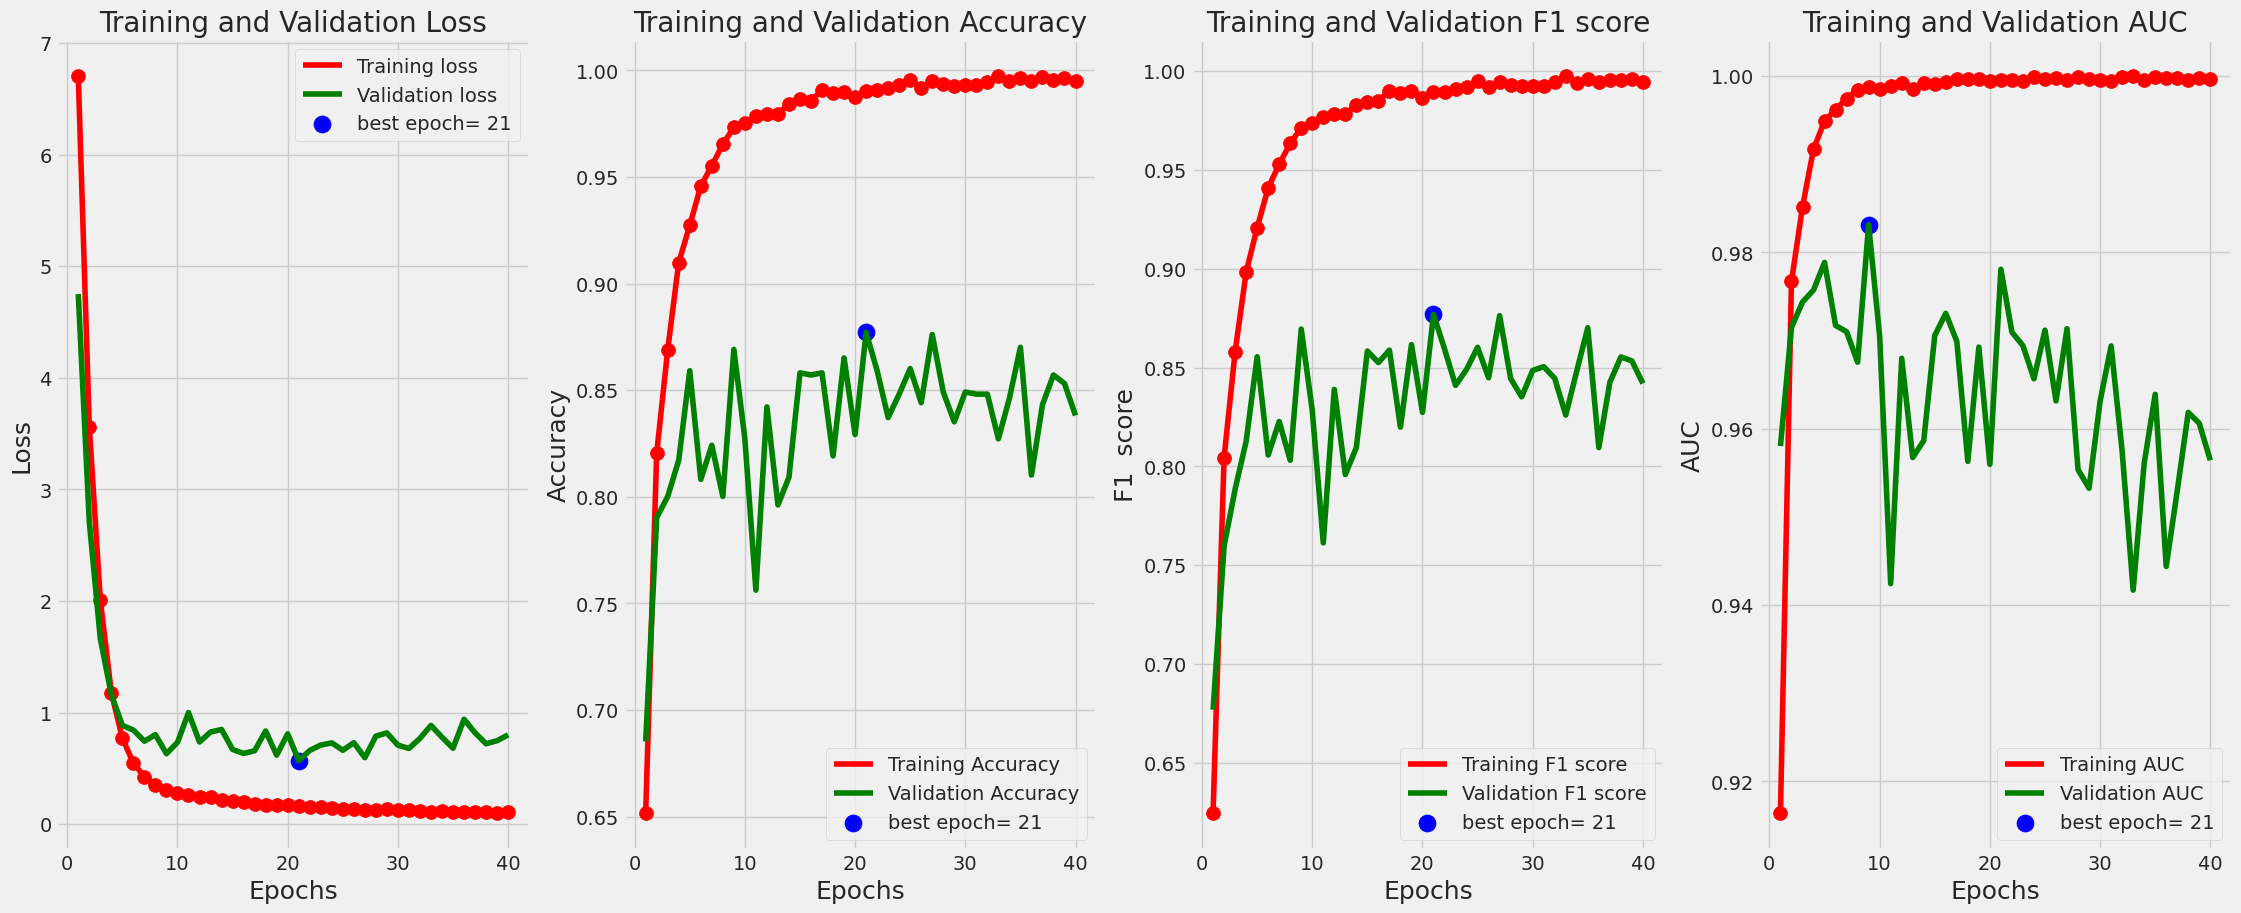

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tr_plot(tr_data):
    start_epoch = 0

    # Extract metrics
    tacc = tr_data.history.get('accuracy', [])
    tloss = tr_data.history.get('loss', [])
    vacc = tr_data.history.get('val_accuracy', [])
    vloss = tr_data.history.get('val_loss', [])
    tf1 = tr_data.history.get('F1_score', [])
    vf1 = tr_data.history.get('val_F1_score', [])
    tauc = tr_data.history.get('auc', [])
    vauc = tr_data.history.get('val_auc', [])

    # Generate epoch numbers
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))

    # Calculate best values
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    auc_index = np.argmax(vauc)
    val_highest_auc = vauc[auc_index]

    # Plotting
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 10))

    # Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label='Best Validation Loss Epoch')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    # Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1, acc_highest, s=150, c='blue', label='Best Validation Accuracy Epoch')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    # F1 Score
    axes[2].plot(Epochs, tf1, 'r', label='Training F1 Score')
    axes[2].plot(Epochs, vf1, 'g', label='Validation F1 Score')
    index_tf1 = np.argmax(tf1)
    tf1max = tf1[index_tf1]
    index_vf1 = np.argmax(vf1)
    vf1max = vf1[index_vf1]
    axes[2].scatter(index_vf1 + 1, vf1max, s=150, c='blue', label='Best Validation F1 Score Epoch')
    axes[2].set_title('Training and Validation F1 Score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1 Score', fontsize=18)
    axes[2].legend()

    # AUC
    axes[3].plot(Epochs, tauc, 'r', label='Training AUC')
    axes[3].plot(Epochs, vauc, 'g', label='Validation AUC')
    axes[3].scatter(auc_index + 1, val_highest_auc, s=150, c='blue', label='Best Validation AUC Epoch')
    axes[3].set_title('Training and Validation AUC')
    axes[3].set_xlabel('Epochs', fontsize=18)
    axes[3].set_ylabel('AUC', fontsize=18)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    return


<a id="eval"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Model Evaluation</b></div>

167/167 [==============================] - 21s 106ms/step
there were 152 errors in 1002 tests for an accuracy of  84.83



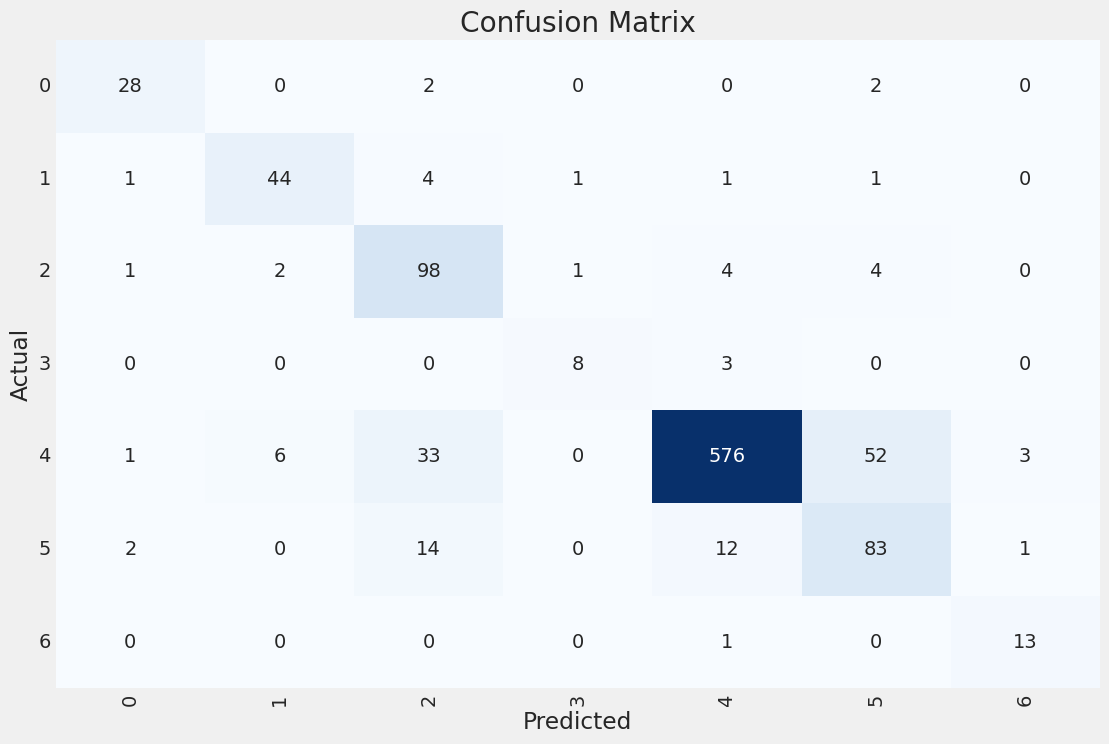

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.8485    0.8750    0.8615        32
           1     0.8462    0.8462    0.8462        52
           2     0.6490    0.8909    0.7510       110
           3     0.8000    0.7273    0.7619        11
           4     0.9648    0.8584    0.9085       671
           5     0.5845    0.7411    0.6535       112
           6     0.7647    0.9286    0.8387        14

    accuracy                         0.8483      1002
   macro avg     0.7797    0.8382    0.8030      1002
weighted avg     0.8732    0.8483    0.8554      1002



In [ ]:
from sklearn.metrics import confusion_matrix

def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_gen)

<a id="xai"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>LIME Explainability</b></div>

The below code is used for Local Interpretable Model-agnostic Explanations (LIME) to understand and visualize the predictions of a deep learning model. It begins by preprocessing an image from a test set, applying superpixel segmentation to create segments that simplify the image. The code then perturbs these segments to generate variations of the image, predicting model outputs for each perturbation. Using these predictions, it constructs a simpler linear model to approximate the complex model's behavior in the vicinity of the input image. The code calculates feature importance from this model, visualizes the superpixels' contributions, and creates a heatmap to illustrate which segments of the image most influence the model's prediction. This process helps in interpreting and explaining the model’s decisions by highlighting key regions that impact the predictions.

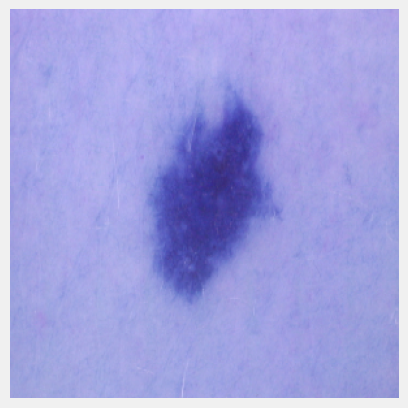

In [ ]:
Xi, _ = test_gen[0]
if len(Xi.shape) == 4:
    Xi = Xi[0]
if Xi.shape[-1] == 3:  # Check if it's a color image
    Xi = cv2.cvtColor(Xi, cv2.COLOR_BGR2RGB)
Xi = cv2.resize(Xi, (299, 299))
Xi = (Xi / 255.0 - 0.5) * 2

plt.imshow(Xi / 2 + 0.5)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
sample, _ = test_gen[0]
preds = model.predict(sample)
preds[0]

1/1 [==============================] - 2s 2s/step


array([1.5310530e-04, 3.3991941e-04, 4.5328791e-04, 1.9632114e-04,
       9.9765873e-01, 9.4890664e-04, 2.4962108e-04], dtype=float32)

In [ ]:
top_pred_classes = preds[0].argsort()
top_pred_classes                #Index of top 5 classes

array([0, 3, 6, 1, 2, 5, 4])

In [ ]:
from skimage.segmentation._quickshift import quickshift

superpixels = quickshift(Xi, kernel_size=10,max_dist=100, ratio=0.5)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

11

In [ ]:
Xi.shape

(299, 299, 3)

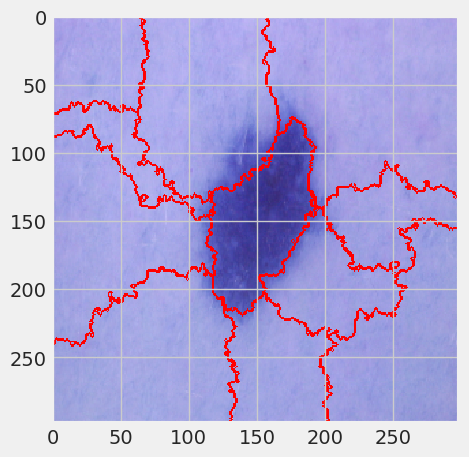

In [ ]:
def mark_boundaries_custom(image, labels):
    boundaries = np.gradient(labels)
    boundary_mask = np.logical_or(boundaries[0] != 0, boundaries[1] != 0)
    marked_image = image.copy()
    marked_image[boundary_mask] = [1, 0, 0]  # Red color for boundaries
    return marked_image


img_with_boundaries = mark_boundaries_custom(Xi/2+0.5, superpixels)
skimage.io.imshow(img_with_boundaries)


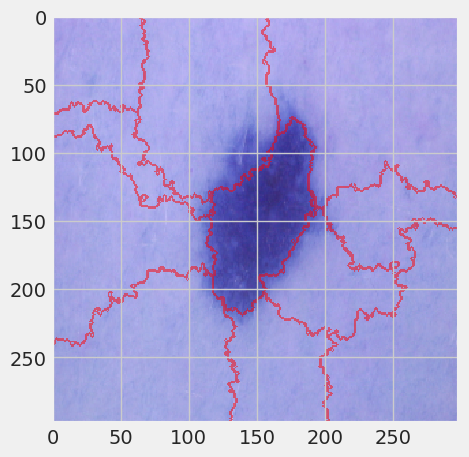

In [ ]:
def mark_boundaries_custom(image, labels, color=(1, 0, 0), alpha=0.5):
    """
    Mark boundaries on an image.

    Parameters:
    - image: The input image.
    - labels: The superpixel labels.
    - color: The boundary color.
    - alpha: The blending factor (0 means only image, 1 means only boundary color).

    Returns:
    - The image with boundaries marked.
    """
    boundaries = np.gradient(labels)
    boundary_mask = np.logical_or(boundaries[0] != 0, boundaries[1] != 0)

    marked_image = image.copy()
    for i in range(3):  # Assuming RGB image
        marked_image[boundary_mask, i] = image[boundary_mask, i] * (1 - alpha) + color[i] * alpha

    return marked_image


img_with_boundaries = mark_boundaries_custom(Xi/2+0.5, superpixels)
skimage.io.imshow(img_with_boundaries)

In [ ]:
# skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
num_perturb = 1000
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

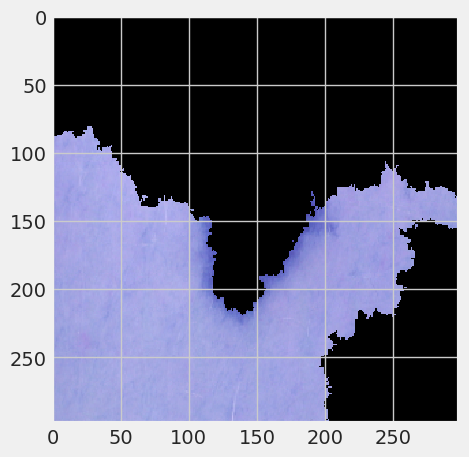

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:], verbose=0)
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(1000, 1, 7)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(1000,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(1000,)

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-1.54680740e-05,  1.83625626e-05,  4.78152337e-05,  1.49168318e-05,
        3.31358215e-05, -4.73033240e-05,  1.98690643e-05, -2.77332174e-05,
       -2.96358141e-06, -3.34243607e-05,  1.12517167e-05])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([1, 6, 4, 2])

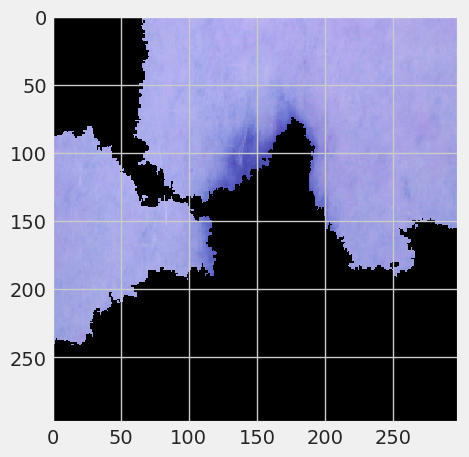

In [ ]:
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

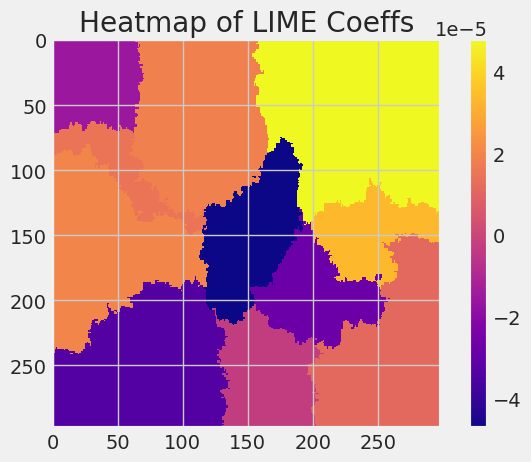

In [ ]:
def create_heat_mask(superpixels_b, coeff):
    # Initialize an empty image
    heat_mask = np.zeros_like(superpixels_b, dtype=float)

    # Iterate over the unique labels of the superpixels
    for idx, label in enumerate(np.unique(superpixels_b)):
        # Set the pixels of the current superpixel to its corresponding coefficient
        heat_mask[superpixels_b == label] = coeff[idx]

    return heat_mask

heat_mask_LIME = create_heat_mask(superpixels, coeff)

plt.imshow(heat_mask_LIME, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of LIME Coeffs')
plt.show()